In [57]:
import pandas as pd
import time
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from LogisticRegression.LogisticRegression import LogisticRegression
import warnings

In [58]:
def parseExcelDataSet(filePath):
    xl = pd.ExcelFile(filePath)
    parsed = xl.parse(xl.sheet_names[0])
    data = np.array(parsed)

    rows, cols = data.shape

    # Classification is in the last column
    Y = data[:, cols - 1]
    X = data[:, :cols - 1]
    X = StandardScaler().fit_transform(X)

    return X, Y

In [59]:
def plot_scores(scores, details, x_values, x_label, title=None, figsize=(16, 9)):
    marks = ['r-', 'b-', 'y-', 'g-']
    colors = ['red', 'blue', 'yellow', 'green']
    plt.figure(figsize=figsize)

    plt.legend(handles=[mpatches.Patch(color=col, label=det) for col, det in zip(colors, details)])
    if title != None:
        plt.title(title)

    for score, mark in zip(scores, marks):
        plt.plot(score, mark)

    plt.ylabel("Success rate")
    plt.xlabel(x_label)
    x_lables = list(x_values[0::np.round(len(x_values) / 10).astype(int)])
    x_lables.append(x_values[len(x_values) - 1])
    plt.ylim(0.5, 1)
    plt.xticks(np.append(np.arange(0, len(x_values), len(x_values) / 10).astype(int), [len(x_values)]), x_lables)
    plt.show()

In [60]:
def summarize_model(model, train_x, train_y, test_x, test_y):
    train_prediction = model.predict(train_x)
    train_errors = float(sum(train_prediction != train_y)) / len(train_y)

    test_prediction = model.predict(test_x)
    test_errors = float(sum(test_prediction != test_y)) / len(test_y)

    return train_errors, test_errors


def run_logistic_regression(X_train, y_train, X_test, y_test, alpha, num_of_features):
    zero_one_y_train = [0 if c == 'M' else 1 for c in y_train]
    zero_one_y_test = [0 if c == 'M' else 1 for c in y_test]

    start = time.time()
    model = LogisticRegression(X_train, zero_one_y_train, alpha, num_of_features)
    iterations_cost_array = model.gradient_decent(200, 0.01)
    train_errors, test_errors = summarize_model(model, X_train, zero_one_y_train, X_test, zero_one_y_test)

    return 1 - test_errors


def run_stochastic_logistic_regression(X_train, y_train, X_test, y_test, alpha, num_of_features):
    zero_one_y_train = [0 if c == 'M' else 1 for c in y_train]
    zero_one_y_test = [0 if c == 'M' else 1 for c in y_test]

    start = time.time()
    model = LogisticRegression(X_train, zero_one_y_train, alpha, num_of_features)
    iterations_cost_array = model.stochastic_gradient_decent(500, 0.01)
    train_errors, test_errors = summarize_model(model, X_train, zero_one_y_train, X_test, zero_one_y_test)

    return 1 - test_errors

In [61]:
def run_k_fold(X, Y, clf, algorithm, draw_scores=False, k=10):
    # k-fold cross validation
    # shuffle data
    index = [i for i in range(len(Y))]
    random.shuffle(index)
    X = X[index, :]
    Y = Y[index]

    # k-fold
    kfold = k
    foldSize = int(len(Y) / kfold)

    # arrage to store training and testing error
    test_score = []
    train_score = []
    allIndex = range(len(Y))

    for k in range(0, kfold):
        test_indexes = range((foldSize * k), foldSize * (k + 1))
        train_indexes = list(set(allIndex) - set(test_indexes))

        train_x, train_y = X[train_indexes, :], Y[train_indexes]
        test_x, test_y = X[test_indexes, :], Y[test_indexes]

        clf.fit(train_x, train_y)
        train_score.append(clf.score(train_x, train_y))
        test_score.append(clf.score(test_x, test_y))

    if draw_scores:
        if algorithm == 'SVM':
            plot_scores([train_score, test_score], ["train_score", "test_score"], range(kfold), "k fold",
                        'SVM: %s kernel with c= %s' % (clf.kernel, clf.C), (4, 2.25))
        if algorithm == 'Neural Network':
            plot_scores([train_score, test_score], ["train_score", "test_score"], range(kfold), "k fold",
                        'Neural Network: %s solver with alpha= %s' % (clf.solver, clf.alpha), (6, 3.5))

    return train_score, test_score


In [62]:
def runKFoldAlgorithm():
    X, Y = parseExcelDataSet("ExcerciseData\\real_project_data.xls")

    print("Running 10-Fold cross validation algorithm using SVM model (figures will pop up, close to continue)...")
    C_arr = np.arange(0.1, 2, 0.5)
    svm_kernels = ["linear", "rbf", "sigmoid"]
    kernels_score = []
    for ker in svm_kernels:
        ker_score = []
        for c in C_arr:
            clf = SVC(kernel=ker, C=c, degree=2)
            train_score, test_score = run_k_fold(X, Y, clf, 'SVM', draw_scores=True)
            ker_score.append(np.mean(test_score))
        kernels_score.append(ker_score)

    print("Running 10-Fold cross validation algorithm using Neural Network model (figures will pop up, close to continue)...")
    alpha_arr = np.arange(0.1, 2, 0.5)
    solvers = ["lbfgs", "sgd", "adam"]
    scores = []
    for solver in solvers:
        nn_score = []
        for a in alpha_arr:
            clf = MLPClassifier(alpha=a, solver=solver)
            train_score, test_score = run_k_fold(X, Y, clf, 'Neural Network', draw_scores=True)
            nn_score.append(np.mean(test_score))
        scores.append(nn_score)

In [63]:
def runAlgorithmComparison():
    print("\n\nRunning 4 machine learning algorithms using different configurations."
          "\nEach algorithm comparison will be illustrated on a detailed graph\n")

    X, Y = parseExcelDataSet("ExcerciseData\\real_project_data.xls")

    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=42)

    print("Running SVM...")
    C_arr = np.arange(0.001, 5, 0.05)
    svm_kernels = ["linear", "rbf", "sigmoid"]
    kernels_score = []
    for ker in svm_kernels:
        ker_score = []
        for c in C_arr:
            clf = SVC(kernel=ker, C=c, degree=2)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            ker_score.append(score)
        kernels_score.append(ker_score)

    plot_scores(kernels_score, svm_kernels, C_arr, "C values", "Running SVM model\nComparison between 3 different kernels and a range of C values")

    print("Running Neural Network...")
    alpha_arr = np.arange(0.0001, 5, 0.05)
    solvers = ["lbfgs", "sgd", "adam"]
    solvers_details = ["lbfgs (Newton) solver", "sgd (stochastic gradient descent) solver",
                       "adam (stochastic gradient-based optimizer) solver"]
    scores = []
    for solver in solvers:
        nn_score = []
        for a in alpha_arr:
            clf = MLPClassifier(alpha=a, solver=solver)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            nn_score.append(score)
        scores.append(nn_score)

    plot_scores(scores, solvers_details, alpha_arr, "alpha values",
                "Running Neural Network model\nComparison between 3 different solvers and a range of alpha values")

    print("Running Logistic Regression model using batch gradient descent...")
    alpha_arr = np.arange(0.05, 5, 0.05)
    num_of_features = [5, 10, 15]
    features_detailes = ["5 features", "10 features", "15 features"]
    scores = []
    for nf in num_of_features:
        score = []
        for a in alpha_arr:
            s = run_logistic_regression(X_train, y_train, X_test, y_test, a, nf)
            score.append(s)
        scores.append(score)

    plot_scores(scores, features_detailes, alpha_arr, "alpha values", "Running Logistic Regression model using BGD\nComparison between 5/10/15 most influences features and range of alpha values")

    print("Running Logistic Regression model using stochastic gradient descent...")
    alpha_arr = np.arange(0.05, 5, 0.05)
    num_of_features = [5, 10, 15]
    features_detailes = ["5 features", "10 features", "15 features"]
    scores = []
    for nf in num_of_features:
        score = []
        for a in alpha_arr:
            s = run_stochastic_logistic_regression(X_train, y_train, X_test, y_test, a, nf)
            score.append(s)
        scores.append(score)

    plot_scores(scores, features_detailes, alpha_arr, "alpha values", "Running Logistic Regression model using SGD\nComparison between 5/10/15 most influences features and range of alpha values")
    print("Comparison finished successfully")

In [64]:
def runBestAlgorithm(argv):
    print("\n\nRunning SVM algorithm while using 'linear' kernel and C=1.7 parameters as second best algorithm."
          "\nThis algorithm was chose as the best algorithm for the given data-set after running K-Fold cross validation algorithm")

    clf = SVC(kernel="linear", C=1.7, degree=2)
    calculateResults(argv, clf, "SVM")

def calculateResults(argv, clf, algorithm):
    X_train, y_train = parseExcelDataSet("ExcerciseData\\real_project_data.xls")
    X_test, y_test = parseExcelDataSet(argv)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_prediction = clf.predict(X_test)

    index_arr = []
    for index, value in enumerate(y_prediction):
        if value != y_test[index]:
            index_arr.append(index)

    print("\nResults for %s where kernel=%s and C=%s:" % (algorithm, clf.kernel, clf.C))
    print("1. Your data-set includes", len(y_test), "classifications.", len(y_test) - len(index_arr), "of them predicted successfully.")
    print("2. Total prediction score is: %.2f%%" % (score * 100))
    print("3. The missed prediction indexes are:\n", index_arr)


--------- Welcome to our machine learning final project ---------

        Menu:
        1. Run detailed algorithms comparison
        2. Run K-Fold cross validation algorithm to determine overfitting
        3. Run the best algorithm for the given data-set
        4. Exit/Quit

------------------------------------------------------------


Running 4 machine learning algorithms using different configurations.
Each algorithm comparison will be illustrated on a detailed graph

Running SVM...


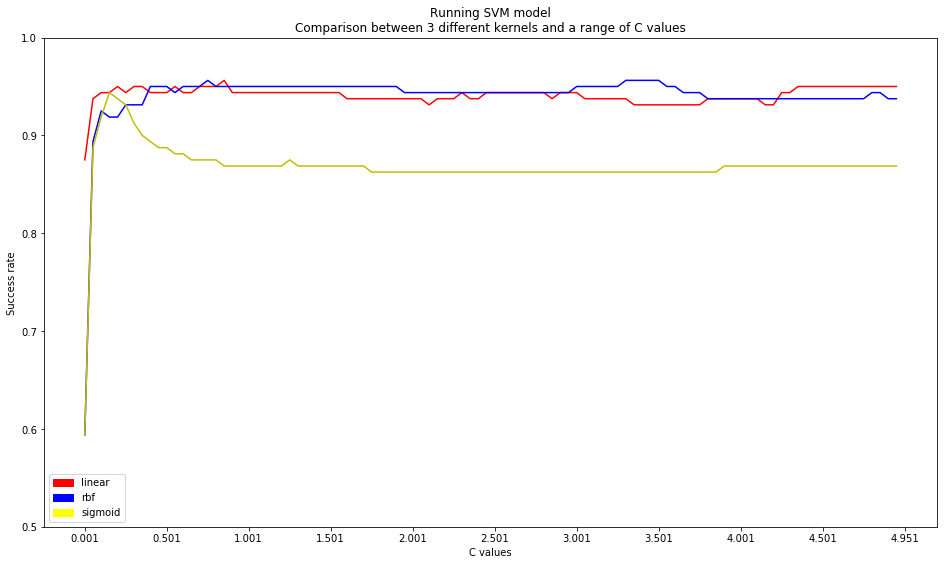

Running Neural Network...


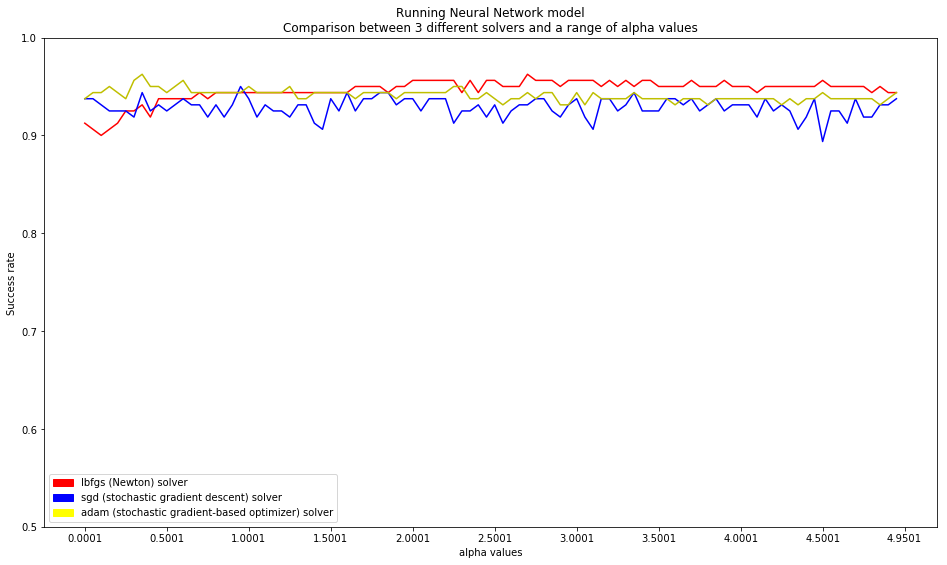

Running Logistic Regression model using batch gradient descent...


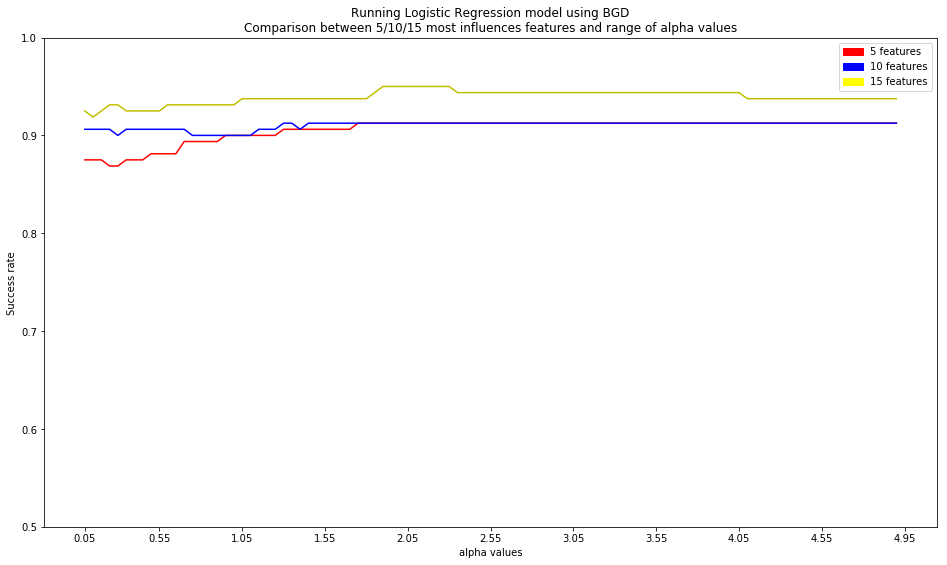

Running Logistic Regression model using stochastic gradient descent...


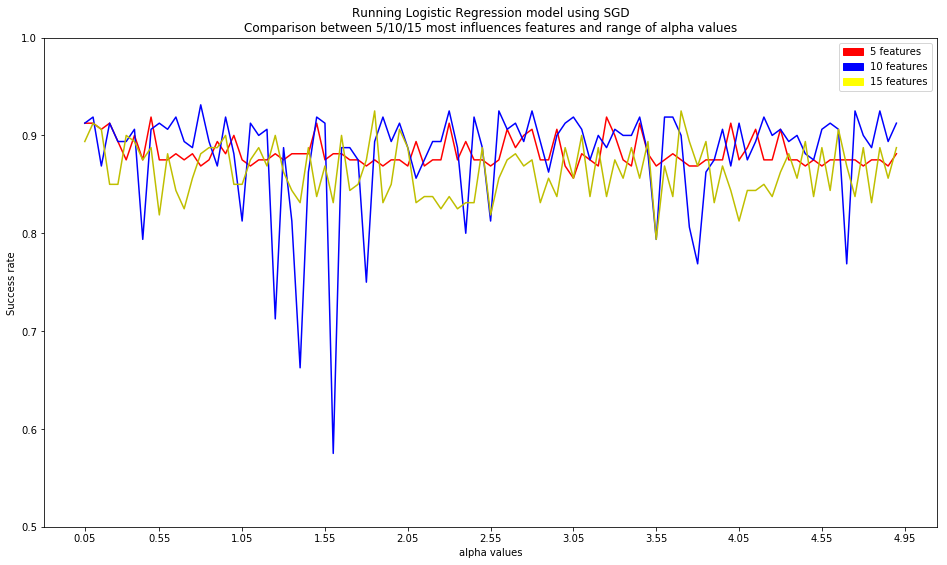

Comparison finished successfully
Running 10-Fold cross validation algorithm using SVM model (figures will pop up, close to continue)...


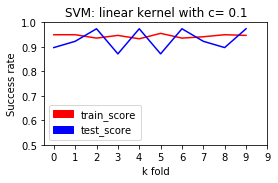

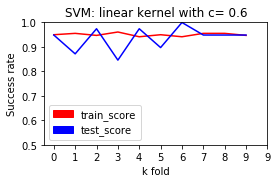

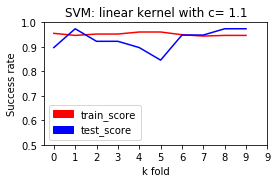

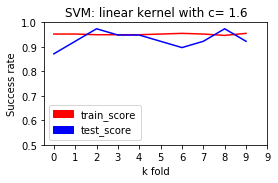

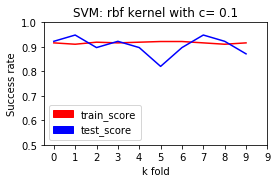

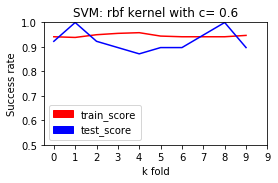

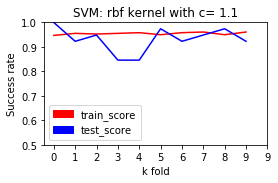

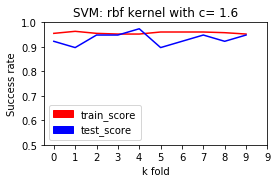

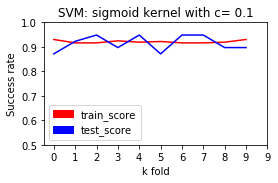

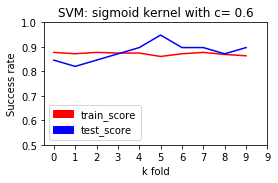

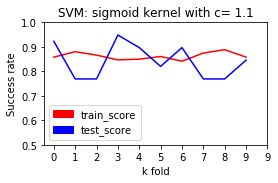

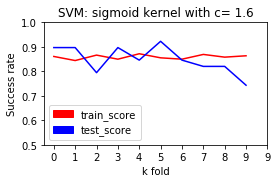

Running 10-Fold cross validation algorithm using Neural Network model (figures will pop up, close to continue)...


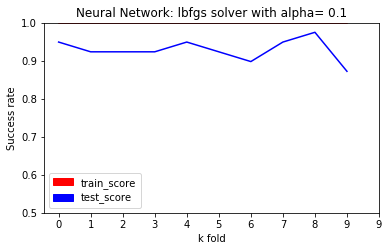

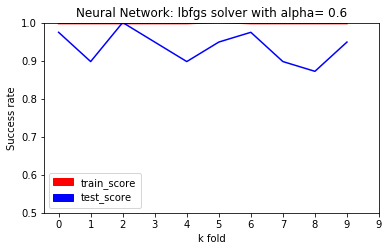

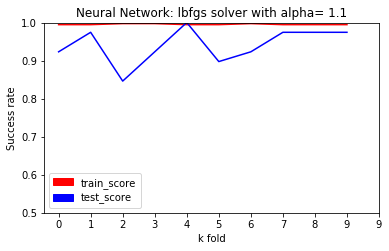

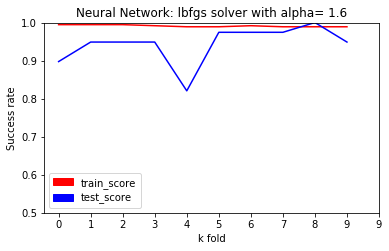

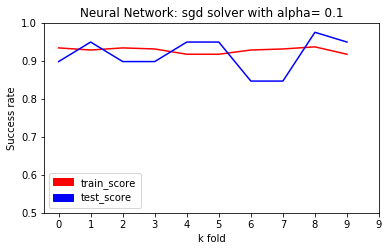

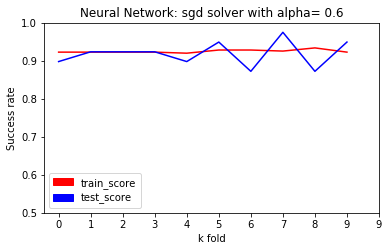

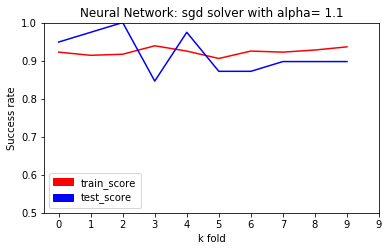

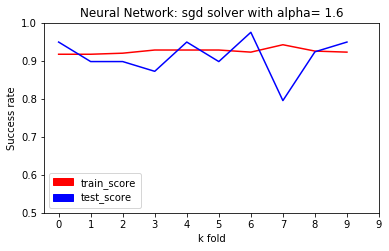

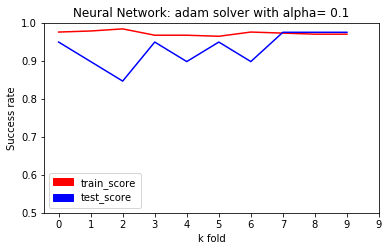

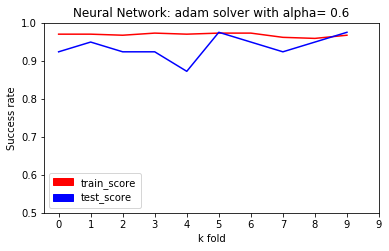

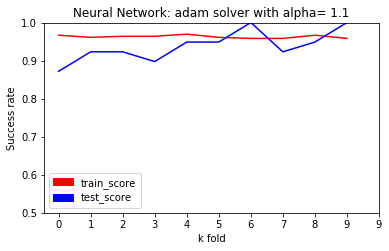

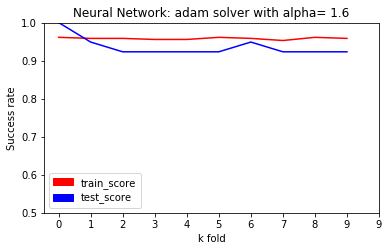

NameError: name 'argv' is not defined

In [69]:
print("\n--------- Welcome to our machine learning final project ---------")
print("""
        Menu:
        1. Run detailed algorithms comparison
        2. Run K-Fold cross validation algorithm to determine overfitting
        3. Run the best algorithm for the given data-set
        4. Exit/Quit""")
print("\n------------------------------------------------------------")
warnings.filterwarnings('ignore')
runAlgorithmComparison()
runKFoldAlgorithm()
runBestAlgorithm(argv)